# Ensemble model

In this notebook we created the final ensemble model of the previous ones trained before.

https://stackoverflow.com/questions/67647843/is-there-a-way-to-ensemble-two-keras-h5-models-trained-for-same-classes


Change base path to point to the zipped models

In [21]:
path_to_models = "/gdrive/MyDrive/ANN challenges/consegna/models"
working_dir = "/content" # Used on Colab, change with './' to run locally

On Colab upload manually the file `dataset.zip`

In [32]:
!unzip -o dataset.zip

Archive:  dataset.zip
  inflating: x_train.npy             
  inflating: y_train.npy             
  inflating: x_train_ov.npy          
  inflating: y_train_ov.npy          
  inflating: x_val.npy               
  inflating: y_val.npy               


### Connect to Drive

In [8]:
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [17]:
import os

!rm -rf models
!mkdir models
os.system("cp -r '%s' /content" % path_to_models)

0

### Import libraries

In [18]:
import tensorflow as tf
import numpy as np
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rc('font', size=16) 
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
import sklearn.preprocessing as sklp
import warnings
import logging

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.9.2


### Set seed for reproducibility

In [29]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

### Load dataset

In [33]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")

x_val = np.load("x_val.npy")
y_val = np.load("y_val.npy")

x_train.shape, x_val.shape, y_train.shape, y_val.shape

((1938, 36, 6), (491, 36, 6), (1938, 12), (491, 12))

### Read models

Models names used for import and for final model structure

In [19]:
models_names = [
    "1DCNN",
    "1DCNN_advanced",
    "BiLSTM",
    "BiLSTM_advanced",
    "2PathsBiLSTM",
    "BiLSTM_noChannel4",
    "Inception"
]

In [26]:
models = []
base_path = os.path.join(working_dir, "models")

for m in models_names:
  # Unzip model
  path = os.path.join(base_path, m + ".zip")
  os.system("unzip " + path) 

  # Rename folder with model name
  os.system("mv model '%s'" % m)
  
  # Load model
  path = os.path.join(working_dir, m)
  models.append(tfk.models.load_model(m))

### Calculate custom weights

We made some tests with custom weights, but we always had worse results.

In [27]:
def calculate_custom_weights(model, x, y, y_raw):

  actual = []
  predicted = []
  y = tf.argmax(y,axis=1)
  actual.append(y)
  predicted.append(tf.argmax(model.predict(x, verbose=0),axis = 1))
    
  predicted = tf.concat(predicted, axis=0)
  actual = tf.concat(actual, axis=0)

  sum_predicted = np.zeros(12)
  sum_expected = np.zeros(12)
  for i in range(len(y)):
    expected = y[i]
    sum_expected[expected] += 1
    if y[i] == predicted[i]:
      sum_predicted[expected] += 1
      
  weights = np.zeros(12)
  for i in range(12):
    weights[i] = sum_predicted[i] / sum_expected[i]

  return weights

In [35]:
# models_weights = []

# for model in models:
#   models_weights.append(calculate_custom_weights(model, x_val, y_val)) # use raw to avoid one hot encoding

# models_weights

### Custom weighted average layer

This layer can be used to calculate the final output by considering the weights of each model.

In [36]:
class WeightedAverageLayer(tf.keras.layers.Layer):
    def __init__(self, w, **kwargs):
      super(WeightedAverageLayer, self).__init__(**kwargs)
      self.w = w

    def call(self, inputs):
      final = self.w[0] * inputs[0]
      for i in range(1, len(inputs)):
        final += self.w[i] * inputs[i]
      return final / len(inputs)

### Create model

Rename models for better visualization

In [38]:
for i in range(len(models_names)):
  models[i]._name = models_names[i]

Put together a new ensemble model composed by the models trained before.

The final result is a standard average of each model final ouput.

In [39]:
input_layer = tfk.Input(shape=(36, 6), name='input_layer')

output_layers = [model(input_layer) for model in models]

# final_output = WeightedAverageLayer(models_weights, name='weighted_average_layer')(output_layers)
final_output = tfk.layers.Average(name='average_layer')(output_layers)

model_ensemble = tfk.Model(inputs=input_layer, outputs=final_output, name='ensemble_model')

for layer in model_ensemble.layers:
  layer.trainable = False

model_ensemble.summary()

Model: "ensemble_model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 36, 6)]      0           []                               
                                                                                                  
 1DCNN (Sequential)             (None, 12)           5948460     ['input_layer[0][0]']            
                                                                                                  
 1DCNN_advanced (Sequential)    (None, 12)           5948460     ['input_layer[0][0]']            
                                                                                                  
 BiLSTM (Sequential)            (None, 12)           4142796     ['input_layer[0][0]']            
                                                                                     

Better print of the overall model

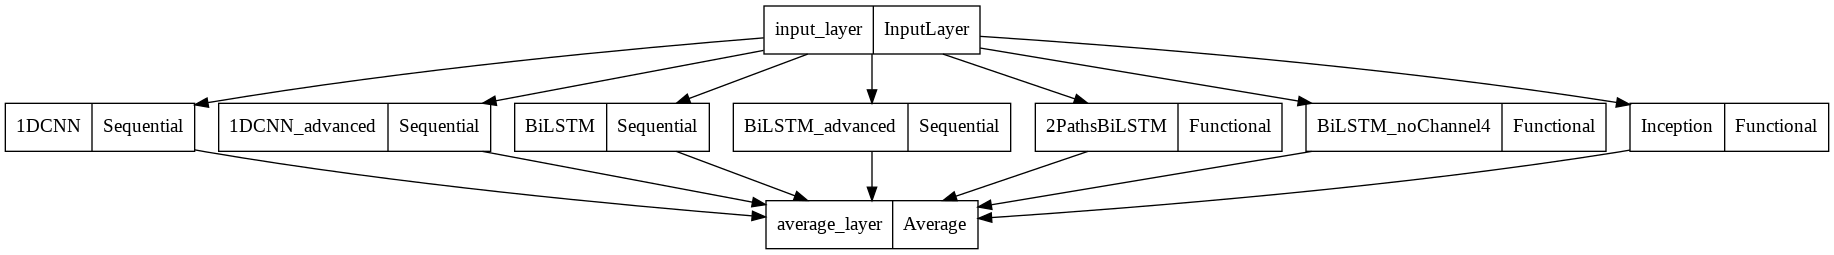

In [40]:
tfk.utils.plot_model(model_ensemble)

### Results

Compile and train only to see results

In [44]:
model_ensemble.compile(optimizer=tfk.optimizers.Adam(), loss=tfk.losses.CategoricalCrossentropy(), metrics=['accuracy'])

history = model_ensemble.fit(
  x=x_train, 
  y=y_train, 
  epochs=1, 
  batch_size=32, 
  validation_data=(x_val, y_val), 
).history

61/61 [==============================] - 33s 155ms/step - loss: 0.6814 - accuracy: 0.8246 - val_loss: 0.9426 - val_accuracy: 0.7108


### Save

In [45]:
model_ensemble.save("model")
!zip -r model.zip model

  adding: model/ (stored 0%)
  adding: model/saved_model.pb (deflated 90%)
  adding: model/variables/ (stored 0%)
  adding: model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: model/variables/variables.index (deflated 75%)
  adding: model/assets/ (stored 0%)
  adding: model/keras_metadata.pb (deflated 95%)
